# <center> ${\text{Data 606 Capstone Project: Manufacturing}}$

#### Import Libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
# Regression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN

np.random.seed(12)

import warnings

warnings.filterwarnings('ignore')

#### Import files using pandas

In [4]:
train02 = pd.read_csv('01_M02_DC_train.csv')
ttf = pd.read_csv('01_M02_DC_train_ttf.csv')
fault = pd.read_csv('01_M02_train_fault_data.csv')

Rename data columns in TTF and view data. 

In [ ]:
ttf = ttf.rename({'TTF_FlowCool Pressure Dropped Below Limit':'Flowcool_Pressure_dropped_below_limit'}, axis='columns')
ttf = ttf.rename({'TTF_Flowcool Pressure Too High Check Flowcool Pump':'Flowcool_Pressure_Too_High'}, axis='columns')
ttf = ttf.rename({'TTF_Flowcool leak':'TTF_Flowcool_leak'}, axis='columns')

In [6]:
train02.head()

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,3283834,01M02,1,9253,10511673,67,1,-0.079428,-0.958814,-0.959509,...,-1.751661,-2.783162,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
1,3283838,01M02,1,9253,10511673,67,1,-0.079419,-0.958928,-0.959651,...,-1.743905,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
2,3283842,01M02,1,9253,10511673,67,1,-0.079409,-0.959156,-0.960006,...,-1.743905,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
3,3283846,01M02,1,9253,10511673,67,1,-0.079420,-0.958928,-0.959297,...,-1.747158,-2.780884,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785
4,3283850,01M02,1,9253,10511673,67,1,-0.079430,-0.959269,-0.959438,...,-1.747158,-2.784389,2.027848,-0.013207,-0.122437,0.0,2.39537,2.871511,3.175941,4.037785


In [7]:
ttf.head()

,time,Flowcool_Pressure_dropped_below_limit,Flowcool_Pressure_Too_High,TTF_Flowcool_leak
0,3283834,623234.0,9146470.0,632514.0
1,3283838,623230.0,9146466.0,632510.0
2,3283842,623226.0,9146462.0,632506.0
3,3283846,623222.0,9146458.0,632502.0
4,3283850,623218.0,9146454.0,632498.0


#### Merge the data. 

In [8]:
alldata = pd.merge(train02, ttf, how='outer', on='time')

#### Create new features 

Create new features for the four different scenarios used in classification for Fault 3 - Flowcool Leak. Below are the lower limits the uppper limits define later. 

In [9]:
numlimit1 = 600
numlimit2 = 2400
numlimit3 = 3600
numlimit4 = 20000

In [10]:
alldata['fault1_a'] = alldata['TTF_Flowcool_leak'].apply(lambda x:1 if x <= numlimit1 else 0)
alldata['fault1_b'] = alldata['TTF_Flowcool_leak'].apply(lambda x:1 if x <= numlimit2 else 0)
alldata['fault1_c'] = alldata['TTF_Flowcool_leak'].apply(lambda x:1 if x <= numlimit3 else 0)
alldata['fault1_d'] = alldata['TTF_Flowcool_leak'].apply(lambda x:1 if x <= numlimit3 else 0)

In [11]:
alldata.head()

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,Flowcool_Pressure_dropped_below_limit,Flowcool_Pressure_Too_High,TTF_Flowcool_leak,fault1_a,fault1_b,fault1_c,fault1_d
0,3283834,01M02,1,9253,10511673,67,1,-0.079428,-0.958814,-0.959509,...,2.871511,3.175941,4.037785,623234.0,9146470.0,632514.0,0,0,0,0
1,3283838,01M02,1,9253,10511673,67,1,-0.079419,-0.958928,-0.959651,...,2.871511,3.175941,4.037785,623230.0,9146466.0,632510.0,0,0,0,0
2,3283842,01M02,1,9253,10511673,67,1,-0.079409,-0.959156,-0.960006,...,2.871511,3.175941,4.037785,623226.0,9146462.0,632506.0,0,0,0,0
3,3283846,01M02,1,9253,10511673,67,1,-0.079420,-0.958928,-0.959297,...,2.871511,3.175941,4.037785,623222.0,9146458.0,632502.0,0,0,0,0
4,3283850,01M02,1,9253,10511673,67,1,-0.079430,-0.959269,-0.959438,...,2.871511,3.175941,4.037785,623218.0,9146454.0,632498.0,0,0,0,0


## Classification

- For each scenario the upper limit is define for Fault 3 - Flowcool Leak.
- The Random Forest Classifier, Gradient Boosting Classifier and the Logistic Regression are run. 
- The models for each scenario are compared. 
- SMOTEENN for the Logistic Regression Scenario 1.

###  Scenario 1: Limit is 10800 and isfailure is 600 - 3 hours, 10 minutes

In [12]:
cl_f1a_data = alldata.drop(['time','Lot','Tool','stage','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_dropped_below_limit','Flowcool_Pressure_Too_High',
                       'fault1_b', 'fault1_c','fault1_d'], axis=1)

In [13]:
clf1data = cl_f1a_data.dropna()

In [14]:
cutoff_1a = 10800

cl_cutoff1a = clf1data.loc[clf1data['TTF_Flowcool_leak']<cutoff_1a].copy()

In [15]:
cl_X1a = cl_cutoff1a.drop(['TTF_Flowcool_leak', 'fault1_a'], axis=1)
cl_Y1a = cl_cutoff1a['fault1_a']

In [16]:
cl_X1a.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
130854,10548007,-0.016305,-0.952501,0.569103,0.219166,-0.060052,0.347284,0.022131,-0.122455,1.0,2.785817,0.021044
130855,10548007,-0.016305,-0.952501,0.569103,0.219166,-0.060052,0.362004,0.022131,-0.122455,1.0,2.785818,0.021044
130856,10548007,-0.016305,-0.952558,0.565479,0.221736,-0.060052,0.362004,0.022131,-0.122455,1.0,2.785822,0.021044
130857,10548007,-0.016305,-0.952672,0.565479,0.219166,-0.066554,0.348512,0.022131,-0.122455,1.0,2.785825,0.021044
130858,10548007,-0.020102,-0.952331,0.565479,0.219166,-0.046787,0.348512,0.022131,-0.122455,1.0,2.785828,0.021044


In [17]:
cl_Y1a.value_counts()

0    25304
1     1901
Name: fault1_a, dtype: int64

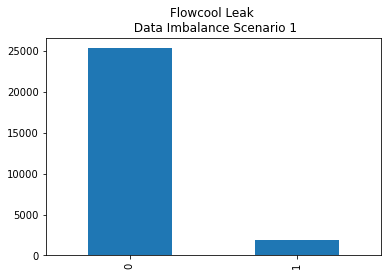

In [83]:
cl_Y1a.value_counts().plot(kind='bar')
plt.title("Flowcool Leak \n Data Imbalance Scenario 1")
plt.xticks()
plt.show()

In [19]:
X_train1a, X_test1a, Y_train1a, Y_test1a = train_test_split(cl_X1a, cl_Y1a, test_size = 0.2, random_state=42)

In [20]:
X_train1a.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
145803,10551521,-0.079480,-0.958587,-2.840944,-2.332807,-1.745656,-2.784389,0.022131,4.530131,0.0,2.806265,0.803526
2211715,11475357,0.031457,0.710672,-0.288881,0.124666,1.405384,0.366562,1.359276,-0.122446,2.0,0.049349,0.021044
917702,10888413,0.007118,0.710727,-0.285107,-0.183921,1.419893,0.358499,0.022131,-0.122455,1.0,-1.507547,-0.278907
917587,10888413,-0.024606,1.546144,0.570147,0.198585,-1.191460,0.365508,-0.980728,-0.122455,1.0,-1.507928,-0.657107
917872,10888413,0.011619,0.710330,-0.288881,-0.185838,1.413639,0.355169,-1.315014,-0.122455,1.0,-1.506983,0.021044


In [21]:
cl_scalar = MinMaxScaler()
cl_scalar.fit(X_train1a)

scl_trainX1a = cl_scalar.transform(X_train1a)
scl_testX1a = cl_scalar.transform(X_test1a)

#### Random Forest Classifier A

In [22]:
rfc_a = RandomForestClassifier(random_state=42)

rfc_a.fit(scl_trainX1a, Y_train1a)

RandomForestClassifier(random_state=42)

In [23]:
rfc_pred_a = rfc_a.predict(scl_testX1a)

rfc_accuracy_a = accuracy_score(Y_test1a, rfc_pred_a)

print('Accuracy Score Random Forest Scenario 1:{:.3f}\n'.format(rfc_accuracy_a))
print('Classification Report Random Forest Scenario 1\n\n',classification_report(Y_test1a, rfc_pred_a))

Accuracy Score Random Forest Scenario 1:0.992

Classification Report Random Forest Scenario 1

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5084
           1       0.95      0.93      0.94       357

    accuracy                           0.99      5441
   macro avg       0.97      0.96      0.97      5441
weighted avg       0.99      0.99      0.99      5441



In [24]:
rfc_cm = confusion_matrix(Y_test1a, rfc_pred_a)

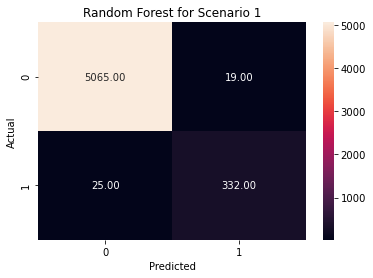

In [25]:
sns.heatmap(rfc_cm, annot=True, fmt='.2f')
plt.title('Random Forest for Scenario 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Gradient Boost Classifier  A

In [26]:
gbc_a = GradientBoostingClassifier(random_state=42)

gbc_a.fit(scl_trainX1a, Y_train1a)

GradientBoostingClassifier(random_state=42)

In [27]:
gbc_pred_a = gbc_a.predict(scl_testX1a)

gbc_accuracy_a = accuracy_score(Y_test1a, rfc_pred_a)

print('Accuracy Score Gradient Boosting Classifier Scenario 1:{:.3f}\n'.format(gbc_accuracy_a))
print('Classification Report Gradient Boosting Classifier Scenario 1\n\n', classification_report(Y_test1a, gbc_pred_a))

Accuracy Score Gradient Boosting Classifier Scenario 1:0.992

Classification Report Gradient Boosting Classifier Scenario 1

               precision    recall  f1-score   support

           0       0.99      1.00      0.99      5084
           1       0.97      0.87      0.92       357

    accuracy                           0.99      5441
   macro avg       0.98      0.93      0.96      5441
weighted avg       0.99      0.99      0.99      5441



In [28]:
gbc_cm = confusion_matrix(Y_test1a, gbc_pred_a)

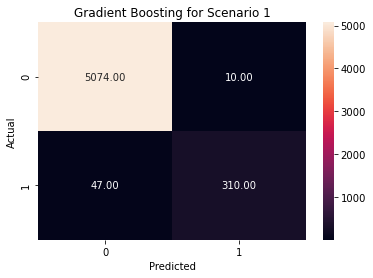

In [29]:
sns.heatmap(gbc_cm, annot=True, fmt='.2f')
plt.title('Gradient Boosting for Scenario 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression A

In [30]:
logreg_a = LogisticRegression()

logreg_a.fit(scl_trainX1a, Y_train1a)

LogisticRegression()

In [33]:
logreg_pred_a = logreg_a.predict(scl_testX1a)

logreg_accuracy_a = accuracy_score(Y_test1a, logreg_pred_a)

print('Accuracy Score Logistic Regression Scenario 1:{:.3f}\n'.format(logreg_accuracy_a))
print('Classification Report Logistic Regression Scenario 1\n\n', classification_report(Y_test1a, logreg_pred_a))

Accuracy Score Logistic Regression Scenario 1:0.934

Classification Report Logistic Regression Scenario 1

               precision    recall  f1-score   support

           0       0.93      1.00      0.97      5084
           1       0.00      0.00      0.00       357

    accuracy                           0.93      5441
   macro avg       0.47      0.50      0.48      5441
weighted avg       0.87      0.93      0.90      5441



#### Cross Validation A

In [34]:
rfc_valscore_a = cross_validate(rfc_a,scl_trainX1a, Y_train1a, cv=5, scoring='f1')

#print("Score:\n",rfc_valscore_a['test_score'])
print("Scores:{:.3f}".format(rfc_valscore_a['test_score'].mean()))
print("Scores:{:.3f}".format(rfc_valscore_a['test_score'].std()))

Scores:0.941
Scores:0.009


In [35]:
gbc_valscore_a = cross_validate(gbc_a,scl_trainX1a, Y_train1a, cv=5, scoring='f1')

#print("Score:\n",rfc_valscore_a['test_score'])
print("Scores:{:.3f}".format(gbc_valscore_a['test_score'].mean()))
print("Scores:{:.3f}".format(gbc_valscore_a['test_score'].std()))

Scores:0.904
Scores:0.012


In [36]:
logreg_valscore_a = cross_validate(logreg_a,scl_trainX1a, Y_train1a, cv=5, scoring='f1')

#print("Score:\n",rfc_valscore_a['test_score'])
print("Scores:{:.3f}".format(logreg_valscore_a['test_score'].mean()))
print("Scores:{:.3f}".format(logreg_valscore_a['test_score'].std()))

Scores:0.000
Scores:0.000


#### Fine Tune Parameters

#### Fine Tuning the Random Forest Classifier

Different hyperparameters are tried out using GridSearchCV to improve performance.

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
rfc_grid = [{'n_estimators':[50,200], 'max_depth':[5,10], 'criterion':['entropy','gini']}]

rfc_cv = RandomForestClassifier()

In [39]:
rfc_gridsearch= GridSearchCV(estimator =rfc_cv, param_grid=rfc_grid, cv=5, return_train_score=True )

rfc_gridsearch.fit(scl_trainX1a, Y_train1a)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [5, 10], 'n_estimators': [50, 200]}],
             return_train_score=True)

In [40]:
rfc_gridsearch.best_score_

0.9914078441507547

In [41]:
rfc_best = rfc_gridsearch.best_estimator_

In [42]:
rfc_best_a = rfc_best.predict(scl_testX1a)

rfc_best_accuracy_a = accuracy_score(Y_test1a, rfc_best_a)

print('Accuracy Score Random Forest Classifer after Fine Tuning Scenario 1:{:.3f}\n'.format(rfc_best_accuracy_a))
print('Classification Report Random Forest Classifier after Fine Tuning Scenario 1\n\n', classification_report(Y_test1a, rfc_best_a))

Accuracy Score Random Forest Classifer after Fine Tuning Scenario 1:0.992

Classification Report Random Forest Classifier after Fine Tuning Scenario 1

               precision    recall  f1-score   support

           0       0.99      1.00      1.00      5084
           1       0.97      0.90      0.94       357

    accuracy                           0.99      5441
   macro avg       0.98      0.95      0.97      5441
weighted avg       0.99      0.99      0.99      5441



#### Fine Tuning the Gradient Boosting Classifier

In [43]:
gbc_grid = [{'n_estimators':[50,150], 'max_depth':[2,5]}]

gbc_cv = GradientBoostingClassifier()

In [44]:
gbc_gridsearch= GridSearchCV(estimator = gbc_cv, param_grid=gbc_grid, cv=5, return_train_score=True )

gbc_gridsearch.fit(scl_trainX1a, Y_train1a)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid=[{'max_depth': [2, 5], 'n_estimators': [50, 150]}],
             return_train_score=True)

In [45]:
gbc_gridsearch.best_score_

0.9922348811164714

In [46]:
gbc_best = gbc_gridsearch.best_estimator_

In [48]:
gbc_best_a = gbc_best.predict(scl_testX1a)

gbc_best_accuracy_a = accuracy_score(Y_test1a, gbc_best_a)

print('Accuracy Score Gradient Boosting after Fine Tuning Scenario 1:{:.3f}\n'.format(gbc_best_accuracy_a))
print('Classification Report Gradient Boosting after Fine Tuning Scenario 1\n\n', classification_report(Y_test1a, gbc_best_a))

Accuracy Score Gradient Boosting after Fine Tuning Scenario 1:0.993

Classification Report Gradient Boosting after Fine Tuning Scenario 1

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5084
           1       0.96      0.93      0.95       357

    accuracy                           0.99      5441
   macro avg       0.98      0.97      0.97      5441
weighted avg       0.99      0.99      0.99      5441



#### Fine Tuning Logistic Regression

In [49]:
grid = [{'C':[0.01,0.1,1], 'penalty':['l1'],'solver':['liblinear']},
        {'C':[0.01,0.1,1], 'penalty':['l2'],'solver':['lbfgs']}]
         
logreg_cv = LogisticRegression(random_state=7, max_iter=200)

In [50]:
logreg_gridsearch = GridSearchCV(estimator =logreg_cv, param_grid=grid, cv=5, return_train_score=True )

logreg_gridsearch.fit(scl_trainX1a, Y_train1a)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200, random_state=7),
             param_grid=[{'C': [0.01, 0.1, 1], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                          'solver': ['lbfgs']}],
             return_train_score=True)

In [51]:
logreg_gridsearch.best_score_

0.9291031223395629

In [52]:
logreg_gridsearch.best_estimator_

LogisticRegression(C=1, max_iter=200, penalty='l1', random_state=7,
                   solver='liblinear')

In [53]:
logreg_bestest =logreg_gridsearch.best_estimator_

In [55]:
logreg_best_a = logreg_bestest.predict(scl_testX1a)

logreg_best_accuracy_a = accuracy_score(Y_test1a, logreg_best_a)

print('Accuracy Score Logistic Regression after Fine Tuning Scenario 1: {:.3f}\n'.format(logreg_best_accuracy_a))
print('Classification Report Logistic Regression after Fine Tuning Scenario 1\n\n', classification_report(Y_test1a, logreg_best_a))

Accuracy Score Logistic Regression after Fine Tuning Scenario 1: 0.934

Classification Report Logistic Regression after Fine Tuning Scenario 1

               precision    recall  f1-score   support

           0       0.93      1.00      0.97      5084
           1       0.00      0.00      0.00       357

    accuracy                           0.93      5441
   macro avg       0.47      0.50      0.48      5441
weighted avg       0.87      0.93      0.90      5441



In [56]:
logreg_cm = confusion_matrix(Y_test1a, logreg_best_a)

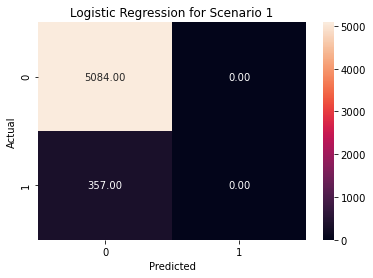

In [57]:
sns.heatmap(logreg_cm, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Scenario 2: Limit is 19800 and failure is 2400 - 5 1/2 hours, 40 minutes

In [58]:
cl_f1b_data = alldata.drop(['time','Lot','Tool','stage','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_dropped_below_limit','Flowcool_Pressure_Too_High',
                       'fault1_a', 'fault1_c','fault1_d'], axis=1)

In [59]:
clf1data_b = cl_f1b_data.dropna()

In [60]:
cutoff_1b = 19800

cl_cutoff1b = clf1data_b.loc[clf1data_b['TTF_Flowcool_leak']<cutoff_1b].copy()

In [61]:
cl_X1b = cl_cutoff1b.drop(['TTF_Flowcool_leak', 'fault1_b'], axis=1)
cl_Y1b = cl_cutoff1b['fault1_b']

In [62]:
cl_X1b.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
128839,10547102,0.011108,0.710727,-0.286165,-0.146636,1.416896,0.348512,-1.4933,-0.122455,1.0,2.779586,0.336645
128840,10547102,0.011108,0.710784,-0.287824,-0.146636,1.416896,0.348512,-1.4933,-0.122455,1.0,2.779589,0.336645
128841,10547102,0.011108,0.710216,-0.287824,-0.146636,1.411886,0.362004,-1.4933,-0.122455,1.0,2.779593,0.336645
128842,10547102,0.011108,0.710841,-0.287824,-0.146636,1.411886,0.362004,-1.4933,-0.122455,1.0,2.779596,0.336645
128843,10547102,0.011108,0.711297,-0.286919,-0.146636,1.411886,0.347284,-1.4933,-0.122455,1.0,2.779599,0.336645


In [63]:
cl_Y1b.value_counts()

0    34966
1     7774
Name: fault1_b, dtype: int64

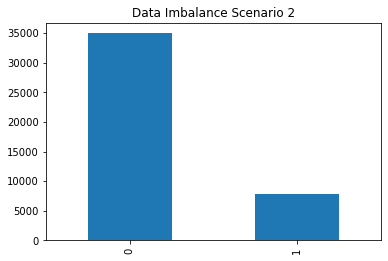

In [82]:
cl_Y1b.value_counts().plot(kind='bar')
plt.title("Data Imbalance Scenario 2")
plt.xticks()
plt.show()

In [65]:
X_train1b, X_test1b, Y_train1b, Y_test1b = train_test_split(cl_X1b, cl_Y1b, test_size = 0.2, random_state=42)

In [66]:
cl_scalar_b = MinMaxScaler()
cl_scalar_b.fit(X_train1b)

scl_trainX1b = cl_scalar.transform(X_train1b)
scl_testX1b = cl_scalar.transform(X_test1b)

#### Random Forest Classifier B

In [67]:
rfc_b = RandomForestClassifier(random_state=42)

rfc_b.fit(scl_trainX1b, Y_train1b)

RandomForestClassifier(random_state=42)

In [68]:
rfc_pred_b = rfc_b.predict(scl_testX1b)

rfc_accuracy_b = accuracy_score(Y_test1b, rfc_pred_b)

print('AccuracyScore Random Forest Scenario 2:{:.3f}\n'.format(rfc_accuracy_b))
print('Classification Report Random Forest Scenario 2\n\n',classification_report(Y_test1b, rfc_pred_b))

AccuracyScore Random Forest Scenario 2:0.989

Classification Report Random Forest Scenario 2

               precision    recall  f1-score   support

           0       0.99      0.99      0.99      6957
           1       0.98      0.96      0.97      1591

    accuracy                           0.99      8548
   macro avg       0.98      0.98      0.98      8548
weighted avg       0.99      0.99      0.99      8548



In [69]:
rfc_cm_b = confusion_matrix(Y_test1b, rfc_pred_b)

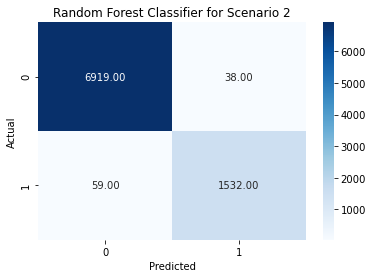

In [70]:
sns.heatmap(rfc_cm_b, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Random Forest Classifier for Scenario 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Gradient Boost Classifier B

In [71]:
gbc_b = GradientBoostingClassifier()

gbc_b.fit(scl_trainX1b, Y_train1b)

GradientBoostingClassifier()

In [84]:
gbc_pred_b = gbc_b.predict(scl_testX1b)

gbc_accuracy_b = accuracy_score(Y_test1b, gbc_pred_b)

print('Accuracy Score Gradient Boost Classifier Scenario 2: {:.3f}\n'.format(gbc_accuracy_b))
print('Classification Report Gradient Boost Classifier Scenario 2\n\n', classification_report(Y_test1b, gbc_pred_b))

Accuracy Score Gradient Boost Classifier Scenario 2: 0.978

Classification Report Gradient Boost Classifier Scenario 2

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      6957
           1       0.99      0.89      0.94      1591

    accuracy                           0.98      8548
   macro avg       0.98      0.95      0.96      8548
weighted avg       0.98      0.98      0.98      8548



In [73]:
gbc_cm_b = confusion_matrix(Y_test1b, gbc_pred_b)

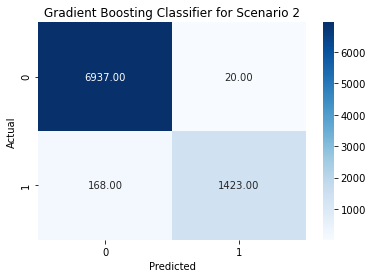

In [74]:
sns.heatmap(gbc_cm_b, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression B

In [75]:
logreg_b = LogisticRegression()

logreg_b.fit(scl_trainX1b, Y_train1b)

LogisticRegression()

In [76]:
logreg_pred_b = logreg_b.predict(scl_testX1b)

logreg_accuracy_b = accuracy_score(Y_test1b, logreg_pred_b)

print('Accuracy Score Logistic Regression Scenario B: {:.3f}\n'.format(logreg_accuracy_b))
print('Classification Report Logistic Regression Scenario B\n\n', classification_report(Y_test1b, logreg_pred_b))

Accuracy Score Logistic Regression Scenario B: 0.815

Classification Report Logistic Regression Scenario B

               precision    recall  f1-score   support

           0       0.86      0.92      0.89      6957
           1       0.50      0.36      0.42      1591

    accuracy                           0.81      8548
   macro avg       0.68      0.64      0.66      8548
weighted avg       0.80      0.81      0.80      8548



In [77]:
logreg_cm_b = confusion_matrix(Y_test1b, logreg_pred_b)

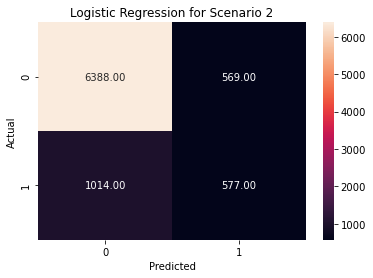

In [78]:
sns.heatmap(logreg_cm_b, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Cross Validation B

In [79]:
rfc_valscore_b = cross_validate(rfc_b,scl_trainX1b, Y_train1b, cv=5, scoring='f1')

print("Scores:{:.3f}".format(rfc_valscore_b['test_score'].mean()))
print("Scores:{:.3f}".format(rfc_valscore_b['test_score'].std()))

Scores:0.965
Scores:0.005


In [80]:
gbc_valscore_b = cross_validate(gbc_b,scl_trainX1b, Y_train1b, cv=5, scoring='f1')

print("Scores:{:.3f}".format(gbc_valscore_b['test_score'].mean()))
print("Scores:{:.3f}".format(gbc_valscore_b['test_score'].std()))

Scores:0.937
Scores:0.005


In [85]:
logreg_valscore_b = cross_validate(logreg_b,scl_trainX1b, Y_train1b, cv=5, scoring='f1')

print("Scores:{:.3f}".format(logreg_valscore_b['test_score'].mean()))
print("Scores:{:.3f}".format(logreg_valscore_b['test_score'].std()))

Scores:0.425
Scores:0.011


### Scenario 3: Limit is 28800 and failure is 3600 - 8 hours, 1 hour

In [86]:
cl_f1c_data = alldata.drop(['time','Lot','Tool','stage','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_dropped_below_limit','Flowcool_Pressure_Too_High',
                       'fault1_a', 'fault1_b','fault1_d'], axis=1)

In [87]:
clf1data_c = cl_f1c_data.dropna()

In [88]:
cutoff_1c = 28800

cl_cutoff1c = clf1data_c.loc[clf1data_c['TTF_Flowcool_leak']<cutoff_1c].copy()

In [89]:
cl_X1c = cl_cutoff1c.drop(['TTF_Flowcool_leak', 'fault1_c'], axis=1)
cl_Y1c = cl_cutoff1c['fault1_c']

In [90]:
cl_X1c.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
126864,10546196,-0.049129,-0.950795,0.563367,0.238441,-0.051796,0.359727,-0.200727,-0.122455,1.0,2.773445,-0.66754
126865,10546196,-0.049129,-0.950852,0.562459,0.238441,-0.051796,0.359727,-0.200727,-0.122455,1.0,2.773448,-0.66754
126866,10546196,-0.049129,-0.951023,0.562459,0.238441,-0.050292,0.353066,-0.200727,-0.122455,1.0,2.773451,-0.66754
126867,10546196,-0.049129,-0.950909,0.562459,0.238441,-0.050292,0.353066,-0.200727,-0.122455,1.0,2.773455,-0.66754
126868,10546196,-0.049129,-0.950852,0.567441,0.238441,-0.055042,0.359727,-0.200727,-0.122455,1.0,2.773456,-0.66754


In [91]:
cl_Y1c.value_counts()

0    42750
1    11291
Name: fault1_c, dtype: int64

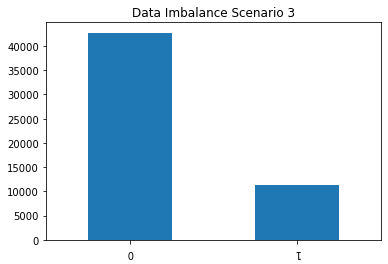

In [92]:
cl_Y1c.value_counts().plot(kind='bar')
plt.title("Data Imbalance Scenario 3")
plt.xticks(rotation=180)
plt.show()

In [93]:
X_train1c, X_test1c, Y_train1c, Y_test1c = train_test_split(cl_X1c, cl_Y1c, test_size = 0.2, random_state=42)

In [94]:
cl_scalar_c = MinMaxScaler()
cl_scalar_c.fit(X_train1c)

scl_trainX1c = cl_scalar.transform(X_train1c)
scl_testX1c = cl_scalar.transform(X_test1c)

#### Random Forest Classifier C

In [95]:
rfc_c = RandomForestClassifier()

rfc_c.fit(scl_trainX1c, Y_train1c)

RandomForestClassifier()

In [96]:
rfc_pred_c = rfc_c.predict(scl_testX1c)

rfc_accuracy_c = accuracy_score(Y_test1c, rfc_pred_c)

print('Accuracy Score Random Forest Classifier Scenario 3: {:.3f}\n'.format(rfc_accuracy_c))
print('Classification Report Random Forest Classifier Scenario 3\n\n',classification_report(Y_test1c, rfc_pred_c))

Accuracy Score Random Forest Classifier Scenario 3: 0.994

Classification Report Random Forest Classifier Scenario 3

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8583
           1       0.98      0.99      0.99      2226

    accuracy                           0.99     10809
   macro avg       0.99      0.99      0.99     10809
weighted avg       0.99      0.99      0.99     10809



In [97]:
rfc_cm_c = confusion_matrix(Y_test1c, rfc_pred_c)

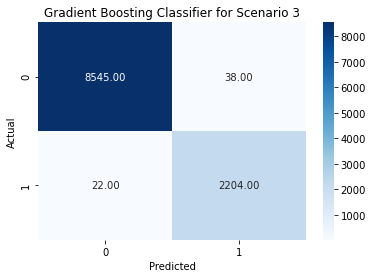

In [98]:
sns.heatmap(rfc_cm_c, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Feature Importance using Random Forest Clssifier

In [99]:
cl_result = permutation_importance(rfc_c, scl_testX1c, Y_test1c, random_state=42)

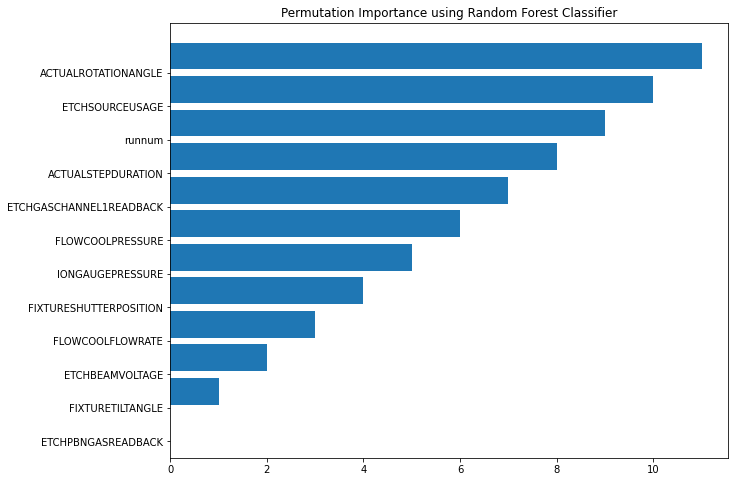

In [100]:
cl_pp = cl_result.importances_mean.argsort()

cl_sort_pp = np.argsort(cl_pp)

pos = np.arange(cl_sort_pp.shape[0])+0.5
y_ticks = np.arange(0,len(cl_X1c.columns))

plt.figure(figsize=(10,8))
plt.barh(pos, cl_pp[cl_sort_pp])
plt.yticks(y_ticks, cl_X1c.columns[cl_sort_pp])
plt.title('Permutation Importance using Random Forest Classifier')
plt.show()

#### Gradient Boost Classifier C

In [101]:
gbc_c = GradientBoostingClassifier()

gbc_c.fit(scl_trainX1c, Y_train1c)

GradientBoostingClassifier()

In [102]:
gbc_pred_c = gbc_c.predict(scl_testX1c)

gbc_accuracy_c = accuracy_score(Y_test1c, gbc_pred_c)

print('Accuracy Score Gradient Boost Classifier Scenario 3: {:.3f}\n'.format(gbc_accuracy_c))
print('Classification Report Gradient Boost Classifier Scenario 3\n\n', classification_report(Y_test1c, gbc_pred_c))

Accuracy Score Gradient Boost Classifier Scenario 3: 0.979

Classification Report Gradient Boost Classifier Scenario 3

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      8583
           1       0.96      0.93      0.95      2226

    accuracy                           0.98     10809
   macro avg       0.97      0.96      0.97     10809
weighted avg       0.98      0.98      0.98     10809



In [103]:
gbc_cm_c = confusion_matrix(Y_test1c, gbc_pred_c)

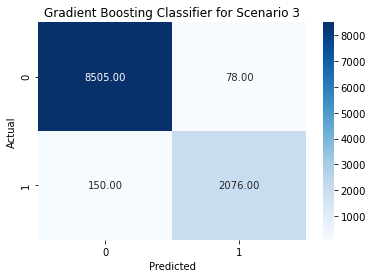

In [104]:
sns.heatmap(gbc_cm_c, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression C

In [105]:
logreg_c = LogisticRegression()

logreg_c.fit(scl_trainX1c, Y_train1c)

LogisticRegression()

In [106]:
logreg_pred_c = logreg_c.predict(scl_testX1c)

logreg_accuracy_c = accuracy_score(Y_test1c, logreg_pred_c)

print('Accuracy Score Logistic Regression Scenario 3: {:.3f}\n'.format(logreg_accuracy_c))
print('Classification Report Logistic Regression Scenario 3\n\n', classification_report(Y_test1c, logreg_pred_c))

Accuracy Score Logistic Regression Scenario 3: 0.836

Classification Report Logistic Regression Scenario 3

               precision    recall  f1-score   support

           0       0.86      0.94      0.90      8583
           1       0.66      0.42      0.52      2226

    accuracy                           0.84     10809
   macro avg       0.76      0.68      0.71     10809
weighted avg       0.82      0.84      0.82     10809



In [107]:
logreg_cm_c = confusion_matrix(Y_test1c, logreg_pred_c)

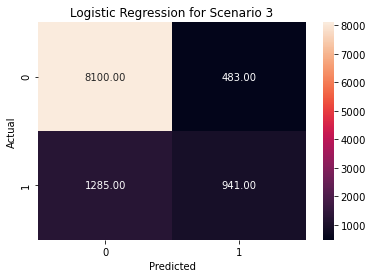

In [108]:
sns.heatmap(logreg_cm_c, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Cross Validation C

In [109]:
rfc_valscore_c = cross_validate(rfc_c,scl_trainX1c, Y_train1c, cv=5, scoring='f1')

print("Scores:\n",rfc_valscore_c['test_score'])
print("Scores:{:.3f}".format(rfc_valscore_c['test_score'].mean()))
print("Scores:{:.3f}".format(rfc_valscore_c['test_score'].std()))

Scores:
 [0.98506637 0.98627128 0.98012148 0.98203924 0.98654216]
Scores:0.984
Scores:0.003


In [110]:
gbc_valscore_c = cross_validate(gbc_c,scl_trainX1c, Y_train1c, cv=5, scoring='f1')

print("Scores:\n",gbc_valscore_c['test_score'])
print("Scores:{:.3f}".format(gbc_valscore_c['test_score'].mean()))
print("Scores:{:.3f}".format(gbc_valscore_c['test_score'].std()))

Scores:
 [0.957927   0.94067797 0.94567971 0.9487901  0.94050992]
Scores:0.947
Scores:0.006


In [112]:
logreg_valscore_c = cross_validate(logreg_c, scl_trainX1c, Y_train1c, cv=5, scoring='f1')

print("Scores:\n",logreg_valscore_c['test_score'])
print("Scores:{:.3f}".format(logreg_valscore_c['test_score'].mean()))
print("Scores:{:.3f}".format(logreg_valscore_c['test_score'].std()))

Scores:
 [0.52256532 0.50906603 0.51071064 0.53074866 0.47560976]
Scores:0.510
Scores:0.019


## Scenario 4: 86400 and failure is 20000 - 24 hours, about 51/2 hours

In [113]:
cl_f1d_data = alldata.drop(['time','Lot','Tool','stage','recipe','recipe_step','ROTATIONSPEED','ETCHBEAMCURRENT','ETCHSUPPRESSORVOLTAGE',
                        'ETCHSUPPRESSORCURRENT','ETCHAUXSOURCETIMER','ETCHAUX2SOURCETIMER','Flowcool_Pressure_dropped_below_limit','Flowcool_Pressure_Too_High',
                       'fault1_a', 'fault1_b','fault1_c'], axis=1)

In [114]:
clf1data_d = cl_f1d_data.dropna()

In [115]:
cutoff_1d = 86400

cl_cutoff1d = clf1data_d.loc[clf1data_d['TTF_Flowcool_leak']<cutoff_1d].copy()

In [116]:
cl_X1d = cl_cutoff1d.drop(['TTF_Flowcool_leak', 'fault1_d'], axis=1)
cl_Y1d = cl_cutoff1d['fault1_d']

In [118]:
cl_X1d.head()

,runnum,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,FLOWCOOLFLOWRATE,FLOWCOOLPRESSURE,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ACTUALSTEPDURATION
113737,10542590,-0.023355,-0.949260,0.566387,0.217228,-0.066554,0.357450,-0.200727,-0.122464,1.0,2.732629,-0.66754
113738,10542590,-0.014866,-0.949487,0.566387,0.217228,-0.048540,0.354293,-0.200727,-0.122464,1.0,2.732633,-0.66754
113739,10542590,-0.011506,-0.949260,0.566387,0.217228,-0.048540,0.354293,-0.200727,-0.122464,1.0,2.732636,-0.66754
113740,10542590,-0.016305,-0.949658,0.574072,0.217228,-0.061544,0.354293,-0.200727,-0.122464,1.0,2.732639,-0.66754
113741,10542590,-0.011887,-0.949601,0.574072,0.217228,-0.061544,0.353066,-0.200727,-0.122464,1.0,2.732644,-0.66754


In [119]:
cl_Y1d.value_counts()

0    154758
1     11291
Name: fault1_d, dtype: int64

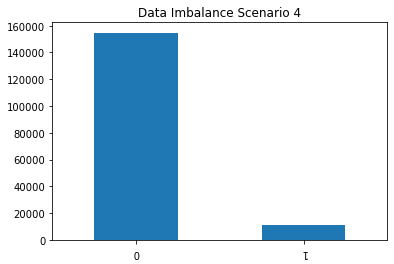

In [120]:
cl_Y1d.value_counts().plot(kind='bar')
plt.title("Data Imbalance Scenario 4")
plt.xticks(rotation=180)
plt.show()

In [121]:
X_train1d, X_test1d, Y_train1d, Y_test1d = train_test_split(cl_X1d, cl_Y1d, test_size = 0.2, random_state=42)

In [122]:
cl_scalar_d = MinMaxScaler()
cl_scalar_d.fit(X_train1d)

scl_trainX1d = cl_scalar.transform(X_train1d)
scl_testX1d = cl_scalar.transform(X_test1d)

#### Random Forest Classifier D

In [123]:
rfc_d = RandomForestClassifier()

rfc_d.fit(scl_trainX1d, Y_train1d)

RandomForestClassifier()

In [124]:
rfc_pred_d = rfc_d.predict(scl_testX1d)

rfc_accuracy_d = accuracy_score(Y_test1d, rfc_pred_d)

print('Accuracy Score Random Forest Classifier Scenario 4: {:.3f}\n'.format(rfc_accuracy_d))
print('Classification Report Random Forest Classifier Scenario 4\n\n',classification_report(Y_test1d, rfc_pred_d))

Accuracy Score Random Forest Classifier Scenario 4: 0.998

Classification Report Random Forest Classifier Scenario 4

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     30943
           1       0.99      0.98      0.99      2267

    accuracy                           1.00     33210
   macro avg       0.99      0.99      0.99     33210
weighted avg       1.00      1.00      1.00     33210



In [125]:
rfc_cm_d = confusion_matrix(Y_test1d, rfc_pred_d)

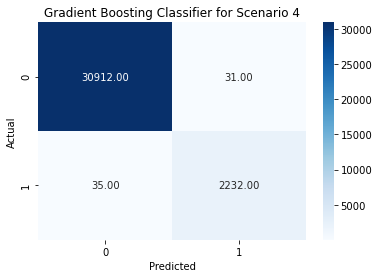

In [126]:
sns.heatmap(rfc_cm_d, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 4')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Feature Importance using Random Forest Clssifier D

In [127]:
cl_result_d = permutation_importance(rfc_d, scl_testX1d, Y_test1d, random_state=42)

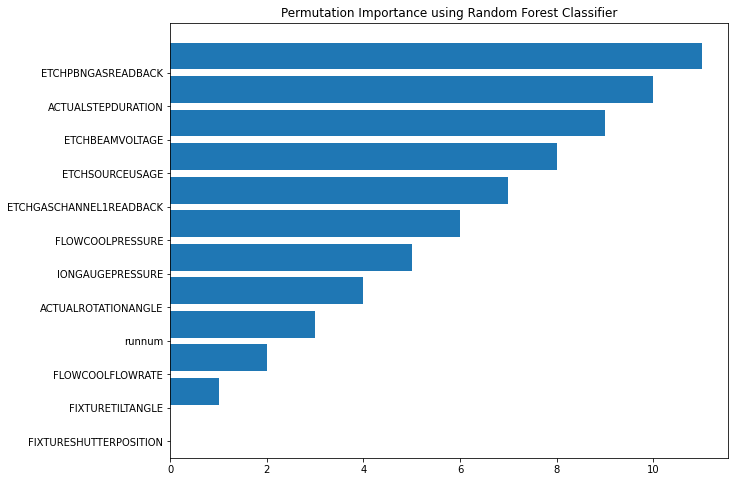

In [128]:
cl_pp_d = cl_result_d.importances_mean.argsort()

cl_sort_pp_d = np.argsort(cl_pp_d)

pos = np.arange(cl_sort_pp_d.shape[0])+0.5
y_ticks = np.arange(0,len(cl_X1d.columns))

plt.figure(figsize=(10,8))
plt.barh(pos, cl_pp_d[cl_sort_pp_d])
plt.yticks(y_ticks, cl_X1d.columns[cl_sort_pp_d])
plt.title('Permutation Importance using Random Forest Classifier')
plt.show()

#### Gradient Boost Classifier D

In [129]:
gbc_d = GradientBoostingClassifier()

gbc_d.fit(scl_trainX1d, Y_train1d)

GradientBoostingClassifier()

In [130]:
gbc_pred_d = gbc_d.predict(scl_testX1d)

gbc_accuracy_d = accuracy_score(Y_test1d, gbc_pred_d)

print('Accuracy Score Gradient Boost Classifier Scenario 4: {:.3f}\n'.format(gbc_accuracy_d))
print('Classification Report Gradient Boost Classifier Scenario 4\n\n', classification_report(Y_test1d, gbc_pred_d))

Accuracy Score Gradient Boost Classifier Scenario 4: 0.984

Classification Report Gradient Boost Classifier Scenario 4

               precision    recall  f1-score   support

           0       0.98      1.00      0.99     30943
           1       0.96      0.79      0.87      2267

    accuracy                           0.98     33210
   macro avg       0.97      0.89      0.93     33210
weighted avg       0.98      0.98      0.98     33210



In [131]:
gbc_cm_d = confusion_matrix(Y_test1d, gbc_pred_d)

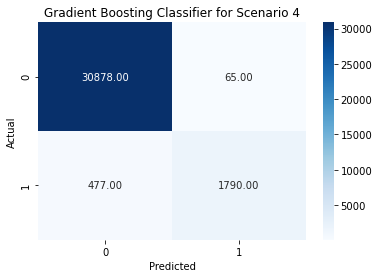

In [132]:
sns.heatmap(gbc_cm_d, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.title('Gradient Boosting Classifier for Scenario 4')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Logistic Regression D

In [133]:
logreg_d = LogisticRegression()

logreg_d.fit(scl_trainX1d, Y_train1d)

LogisticRegression()

In [134]:
logreg_pred_d = logreg_d.predict(scl_testX1d)

logreg_accuracy_d = accuracy_score(Y_test1d, logreg_pred_d)

print('Accuracy Score Logistic Regression Scenario 4: {:.3}\n'.format(logreg_accuracy_d))
print('Classification Report Logistic Regression Scenario 4\n\n', classification_report(Y_test1d, logreg_pred_d))

Accuracy Score Logistic Regression Scenario 4: 0.932

Classification Report Logistic Regression Scenario 4

               precision    recall  f1-score   support

           0       0.93      1.00      0.96     30943
           1       0.00      0.00      0.00      2267

    accuracy                           0.93     33210
   macro avg       0.47      0.50      0.48     33210
weighted avg       0.87      0.93      0.90     33210



In [135]:
logreg_cm_d = confusion_matrix(Y_test1d, logreg_pred_d)

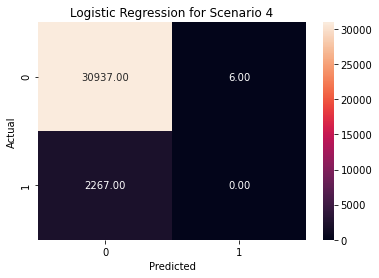

In [136]:
sns.heatmap(logreg_cm_d, annot=True, fmt='.2f')
plt.title('Logistic Regression for Scenario 4')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Cross Validation D

In [137]:
rfc_valscore_d = cross_validate(rfc_d,scl_trainX1d, Y_train1d, cv=5, scoring='f1')

print("Scores:\n",rfc_valscore_d['test_score'])
print("Scores:{:.3f}".format(rfc_valscore_d['test_score'].mean()))
print("Scores:{:.3f}".format(rfc_valscore_d['test_score'].std()))

Scores:
 [0.98451327 0.98047842 0.98245614 0.97653878 0.98449612]
Scores:0.982
Scores:0.003


In [138]:
gbc_valscore_d = cross_validate(gbc_d,scl_trainX1d, Y_train1d, cv=5, scoring='f1')

print("Scores:\n",gbc_valscore_d['test_score'])
print("Scores:{:.3f}".format(gbc_valscore_d['test_score'].mean()))
print("Scores:{:.3f}".format(gbc_valscore_d['test_score'].std()))

Scores:
 [0.87836638 0.88280785 0.91126678 0.88526534 0.8828614 ]
Scores:0.888
Scores:0.012


In [139]:
logreg_valscore_d = cross_validate(logreg_d, scl_trainX1d, Y_train1d, cv=5, scoring='f1')

print("Scores:\n",logreg_valscore_d['test_score'])
print("Scores:{:.3f}".format(logreg_valscore_d['test_score'].mean()))
print("Scores:{:.3f}".format(logreg_valscore_d['test_score'].std()))

Scores:
 [0.00110375 0.         0.01208791 0.00110497 0.00110375]
Scores:0.003
Scores:0.005


#### Model Comparison

In [140]:
TTF_FlowcoolLeak = pd.DataFrame({
    'Fault 3 Models':['Random Forest Classifier','Gradient Boosting Classifier','Logistic Regression'],
       'Scenario 1':[rfc_valscore_a['test_score'].mean(),gbc_valscore_a['test_score'].mean(),logreg_valscore_a['test_score'].mean()],
       'Scenario 2':[rfc_valscore_b['test_score'].mean(),gbc_valscore_b['test_score'].mean(),logreg_valscore_b['test_score'].mean()] , 
        'Scenario 3':[rfc_valscore_c['test_score'].mean(),gbc_valscore_c['test_score'].mean(),logreg_valscore_c['test_score'].mean()],
        'Scenario 4':[rfc_valscore_d['test_score'].mean(),gbc_valscore_d['test_score'].mean(),logreg_valscore_d['test_score'].mean()],
})


In [141]:
TTF_FlowcoolLeak

,Fault 3 Models,Scenario 1,Scenario 2,Scenario 3,Scenario 4
0,Random Forest Classifier,0.940691,0.964918,0.984008,0.981697
1,Gradient Boosting Classifier,0.903621,0.937468,0.946717,0.888114
2,Logistic Regression,0.000000,0.425200,0.509740,0.003080


#### SMOTEENN

SMOTTEENN applied to Scenario 1 to improve the performance of the Logistic Regression.

In [142]:
smote = SMOTEENN()

X_res, Y_res = smote.fit_resample(scl_trainX1a, Y_train1a.ravel())
X_res_test, Y_res_test = smote.fit_resample(scl_testX1a, Y_test1a.ravel())

In [143]:
smote_rfc = LogisticRegression(max_iter=300)

smote_rfc.fit(X_res, Y_res)

LogisticRegression(max_iter=300)

In [144]:
smote_pred = smote_rfc.predict(X_res_test)

smote_rf_accuracy = accuracy_score(Y_res_test, smote_pred)

print('Accuracy Score Logistic Regression after SMOTEENN Scenario 1: {:.3f}\n'.format(smote_rf_accuracy))
print('Classification Report Logistic Regression after SMOTEENN Scenario 1 \n\n', classification_report(Y_res_test, smote_pred))

Accuracy Score Logistic Regression after SMOTEENN Scenario 1: 0.796

Classification Report Logistic Regression after SMOTEENN Scenario 1 

               precision    recall  f1-score   support

           0       0.78      0.81      0.79      4725
           1       0.81      0.79      0.80      5000

    accuracy                           0.80      9725
   macro avg       0.80      0.80      0.80      9725
weighted avg       0.80      0.80      0.80      9725



**Note** Even though the overall performance of the Logistic Regression decreased the f1-score in prediciting isfailure significantly improved. 

In [146]:
logreg_smote_a = confusion_matrix(Y_res_test, smote_pred)

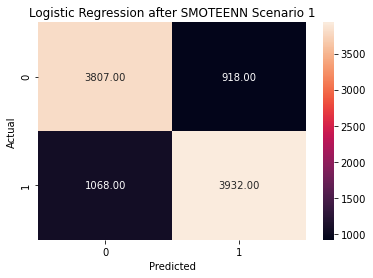

In [147]:
sns.heatmap(logreg_smote_a, annot=True, fmt='.2f')
plt.title('Logistic Regression after SMOTEENN Scenario 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()